# Домашнее задание по теме «Временные ряды, общая теория»
Проанализируйте ряды и сделайте их стационарными.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

# Отображение графиков

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

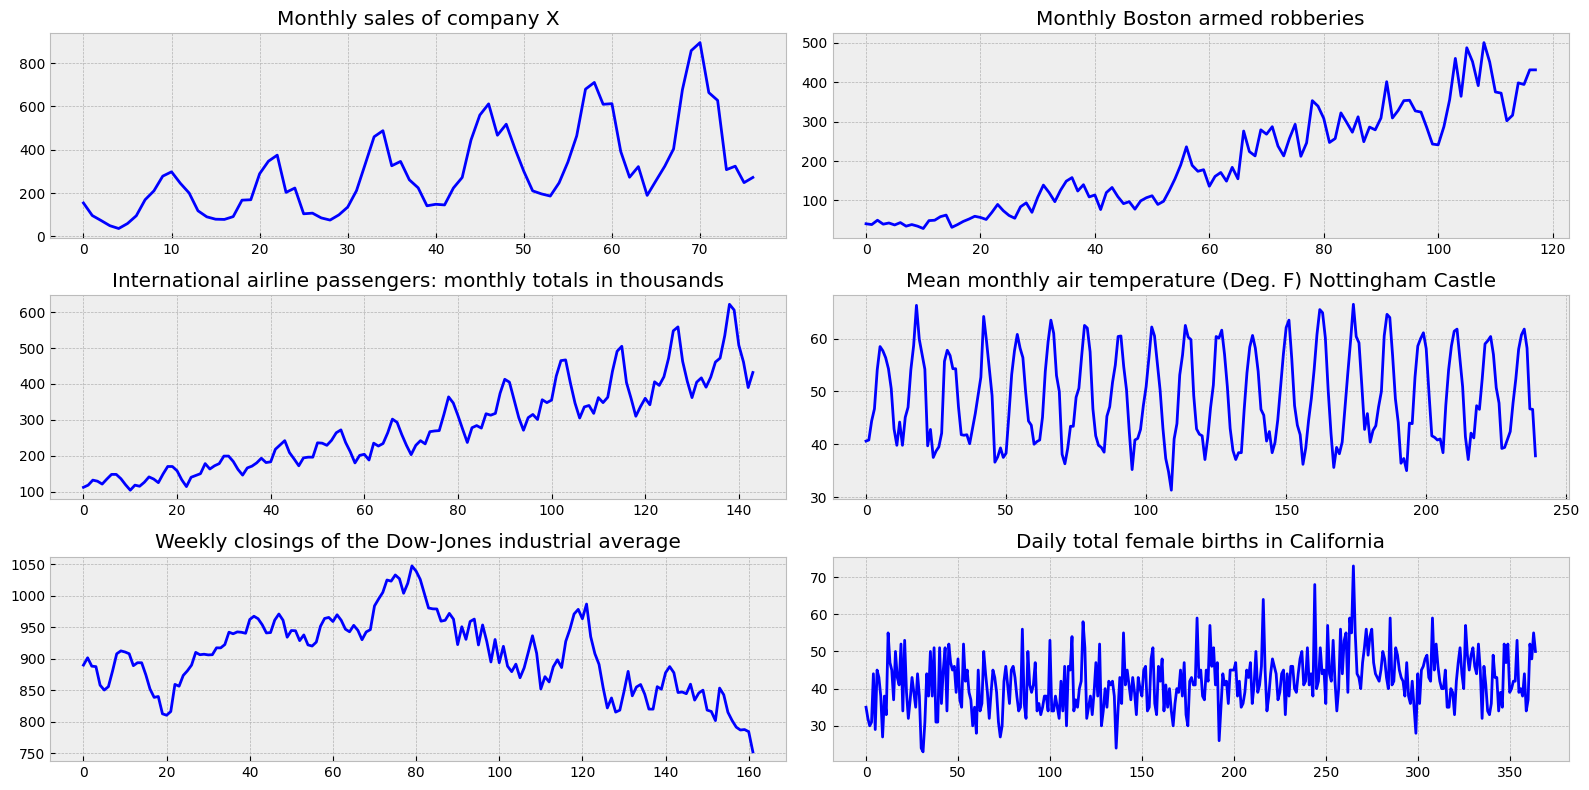

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

# 5_для weekly-closings-of-the-dowjones-.csv


In [7]:
# Преобразование столбца 'Week' в формат datetime, указав формат вручную
dowjones_closing['Week'] = pd.to_datetime(dowjones_closing['Week'] + '-0', format='%Y-W%W-%w')
dowjones_closing.set_index('Week', inplace=True)

# Проверка данных
print(dowjones_closing.head())

             Close
Week              
1971-07-11  890.19
1971-07-18  901.80
1971-07-25  888.51
1971-08-01  887.78
1971-08-08  858.43


In [9]:
### 1. Удаление тренда Для удаления тренда используем линейную регрессию:
# Удаление тренда с помощью линейной регрессии
X = np.arange(len(dowjones_closing)).reshape(-1, 1)
y = dowjones_closing['Close'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
detrended = dowjones_closing['Close'] - trend.flatten()

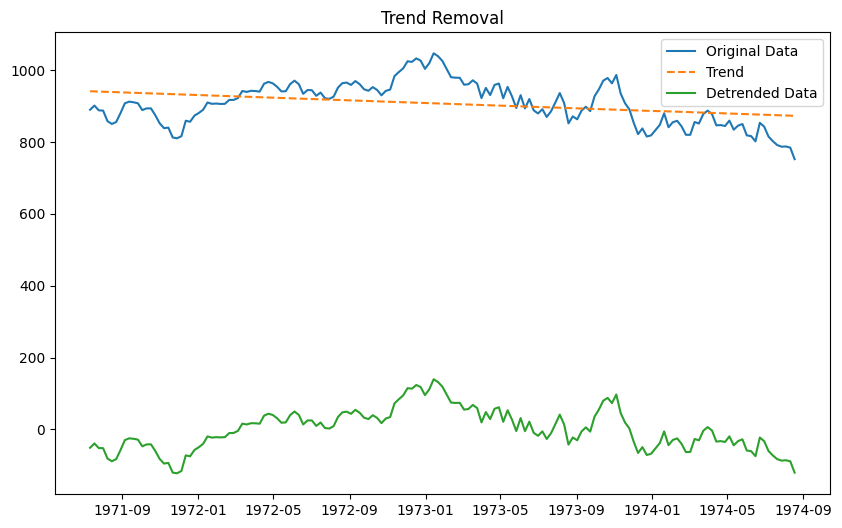

In [11]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(dowjones_closing.index, dowjones_closing['Close'], label='Original Data')
plt.plot(dowjones_closing.index, trend, label='Trend', linestyle='--')
plt.plot(dowjones_closing.index, detrended, label='Detrended Data')
plt.legend()
plt.title('Trend Removal')
plt.show()

In [12]:
### 2. Удаление сезонности Для удаления сезонности используем средние сезонные значения:
# Удаление сезонности
seasonal_means = detrended.groupby(detrended.index.month).mean()
deseasonalized = detrended - detrended.index.map(lambda x: seasonal_means[x.month])

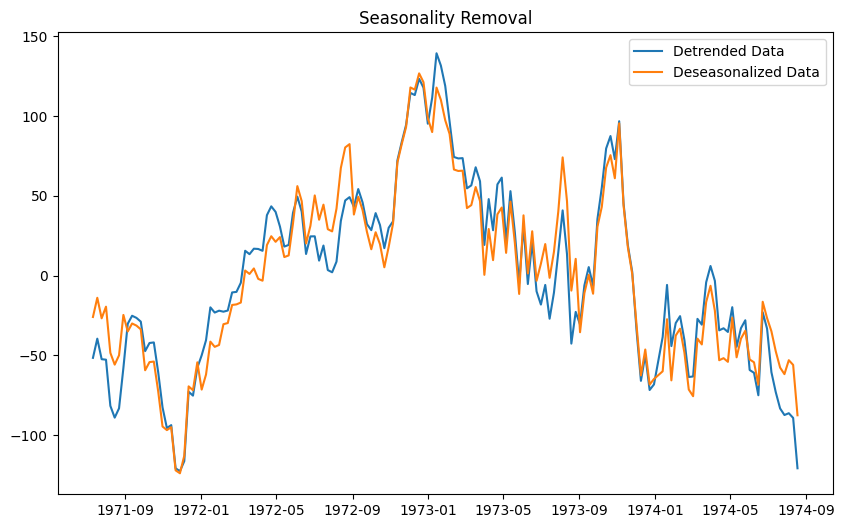

In [13]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(dowjones_closing.index, detrended, label='Detrended Data')
plt.plot(dowjones_closing.index, deseasonalized, label='Deseasonalized Data')
plt.legend()
plt.title('Seasonality Removal')
plt.show()

In [14]:
### 3. Удаление цикличности Для удаления цикличности используем фильтр Ходрика-Прескотта:
# Удаление цикличности с помощью фильтра Ходрика-Прескотта
cycle, trend = sm.tsa.filters.hpfilter(deseasonalized, 1600)
cleaned_data = deseasonalized - cycle

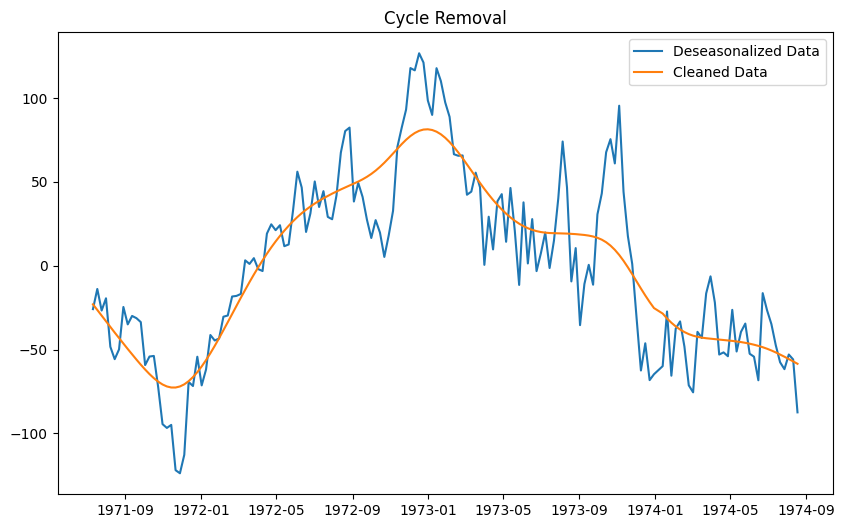

In [15]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(dowjones_closing.index, deseasonalized, label='Deseasonalized Data')
plt.plot(dowjones_closing.index, cleaned_data, label='Cleaned Data')
plt.legend()
plt.title('Cycle Removal')
plt.show()

In [16]:
# Проверка стационарности ряда с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

In [17]:
# Вывод начальных данных и проверка их стационарности
print("Проверка начальных данных на стационарность:")
test_stationarity(dowjones_closing['Close'])

Проверка начальных данных на стационарность:
ADF Statistic: -1.3146254984911683
p-value: 0.6224548515589733
Critical Values:
   1%, -3.471633386932248
Critical Values:
   5%, -2.8796651107461972
Critical Values:
   10%, -2.576433647235832


In [19]:
# Дифференцирование временного ряда для достижения стационарности
dowjones_closing['Count_diff'] = dowjones_closing['Close'].diff().dropna()

# Проверка стационарности дифференцированного ряда
print("\nПроверка дифференцированных данных на стационарность:")
test_stationarity(dowjones_closing['Count_diff'].dropna())


Проверка дифференцированных данных на стационарность:
ADF Statistic: -13.025207881234948
p-value: 2.4075864037417794e-24
Critical Values:
   1%, -3.4718957209472654
Critical Values:
   5%, -2.8797795410156253
Critical Values:
   10%, -2.5764947265625


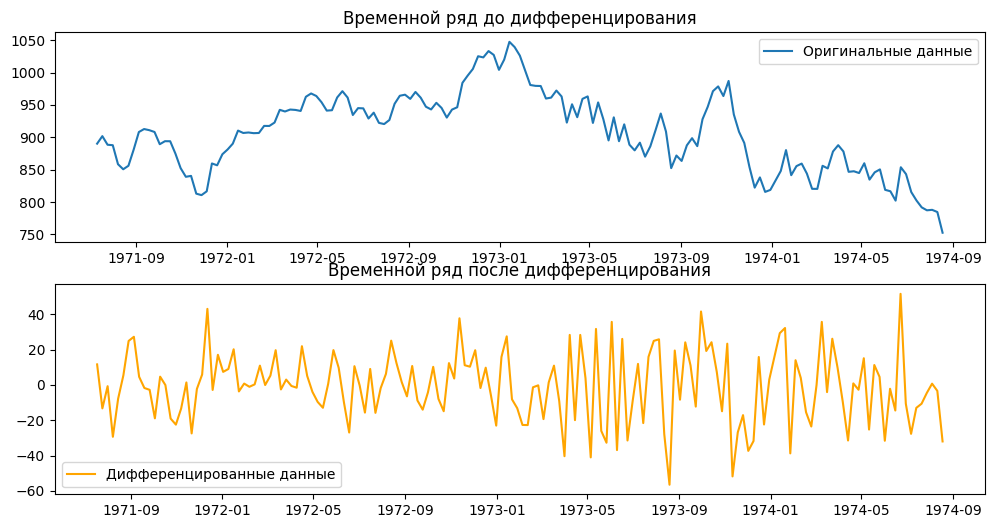

In [20]:
# Визуализация данных до и после дифференцирования
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(dowjones_closing['Close'], label='Оригинальные данные')
plt.title('Временной ряд до дифференцирования')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(dowjones_closing['Count_diff'], label='Дифференцированные данные', color='orange')
plt.title('Временной ряд после дифференцирования')
plt.legend()